# Gym Workout

TODO

NOW
- See if our new env model is any better
- combine our differentiable env model with a q network
- make another network who tries to tell if she's in the real env or the env_model

LATER
- Penalize the env for long-term differences
- Consider the reward to be a part of the observation
- Make env_model training stocastic

DONE
- Make the agent training stochastic
- Try the simann approach

Imports

In [ ]:
import gym
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=3)
import random
import datetime
import itertools
import math

import matplotlib
#matplotlib.use("Pdf")
import matplotlib.pyplot as plt
%matplotlib inline

Create the session. An interactive session is a session that is automatically your default session.

In [2]:
sess = tf.InteractiveSession()

# My own little library of helper functions!

In [3]:
def fc(input_tensor, in_size, out_size, collection=None, non_linearity=tf.nn.sigmoid):
    
    collections = [tf.GraphKeys.VARIABLES, tf.GraphKeys.TRAINABLE_VARIABLES]
    if collection is not None:
        collections.append(collection)
        
    W = tf.get_variable(
        name="W",
        initializer=tf.truncated_normal(
            shape=[in_size, out_size],
            mean=0.0,
            stddev=0.1
        ),
        collections=collections
    )
    
    b = tf.get_variable(
        name="b",
        initializer=tf.constant(
            value=0.1,
            shape=[out_size]
        ),
        collections=collections
    )
    
    return non_linearity( tf.matmul(input_tensor, W) + b )

# fc test
fc_test_template = tf.make_template("fc_test_template", fc, in_size=2, out_size=2)
op = fc_test_template([[0., 1.]])
tf.initialize_all_variables().run()
print op.eval()

def fc_stack(input_tensor, list_of_sizes, collection=None):
    result = input_tensor
    
    for layer_index in xrange(len(list_of_sizes)-1):

        with tf.variable_scope("layer"+str(layer_index)):
        
            if layer_index == len(list_of_sizes)-2:
                non_linearity = tf.identity
            else:
                non_linearity = tf.nn.relu
        
            result = fc(
                result,        
                in_size=list_of_sizes[layer_index],
                out_size=list_of_sizes[layer_index+1],
                collection=collection,
                non_linearity=non_linearity
            )
        
    return result

# fc_stack test
fc_stack_test_template = tf.make_template("fc_stack_test_template", fc_stack, list_of_sizes=[2, 3, 2])
op = fc_stack_test_template([[0., 1.]])
tf.initialize_all_variables().run()
print op.eval()

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def one_hot(index, name="one_hot"):
    return tf.one_hot(indices=index, depth=env.observation_space.n, on_value=1, off_value=0, axis=None, name=name).eval()

def getFeedDict(observation):
    if type(env.observation_space) == gym.spaces.discrete.Discrete:
        return {x:[one_hot(observation)]}
    elif type(env.observation_space) == gym.spaces.box.Box:
        return {x:[observation]}
    else:
        print "ERR"
        
class InitializeNewVariables:
    def __enter__(self):
        self.temp = set(tf.all_variables())
    def __exit__(self, type, value, traceback):
        sess.run(tf.initialize_variables(set(tf.all_variables()) - self.temp))

        
### OpenAI Gym specific stuff ###
def bound_to_env_action_space(my_action):
    my_action = tf.maximum(my_action, env.action_space.low)
    my_action = tf.minimum(my_action, env.action_space.high)
    return my_action
    
def bound_to_env_observation_space(my_observation):
    my_observation = tf.maximum(my_observation, env.observation_space.low)
    my_observation = tf.minimum(my_observation, env.observation_space.high)
    return my_observation

[[ 0.533  0.523]]
[[ 0.088  0.114]]


# Choose an environment

In [4]:
# env = gym.make('ConfirmationBiasEasy-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('TwoRoundNondeterministicReward-v0')
# env = gym.make('CartPole-v0')
env = gym.make("Pendulum-v0")

print(env.action_space)
ACTION_DIMS = env.action_space.shape[0]
print(env.observation_space)
OBSERVATION_DIMS = env.observation_space.shape[0]

[2016-06-10 21:19:43,917] Making new env: Pendulum-v0


Box(1,)
Box(3,)


These lists store the data from when we run our model

In [5]:
actions = []
observations = []
rewards = []
dones = []
initial_observations = []

# This is the actual simulator.

In [6]:
def generate_data(epsilon=0.0, num_episodes=2, episode_len=200, render=True, feed_dict={}):
    total_reward = 0
    
    for i_episode in range(num_episodes):
        observation = env.reset()
        observation = observation.astype(np.float32)
        initial_observations.append(observation)


        for timestep in xrange(episode_len):
            if render:
                env.render()

            if random.random() < epsilon:
                action = env.action_space.sample() #choose a random action
            else:
                feed_dict[agent_in] = np.reshape(observation, [1, 3])
                action = bound_to_env_action_space(agent_out).eval(feed_dict)[0]

            old_observation = observation

            observation, reward, done, info = env.step(action)
            total_reward += reward
            observation = observation.astype(np.float32)

            actions.append(action)
            observations.append(observation)
            rewards.append(reward)
            dones.append(done)

            if done:
                print("Episode finished after {} timesteps".format(timestep+1))
                break

    print "We now have " + str(len(observations)) + " observations in total."
    
    return total_reward / (num_episodes * episode_len)

In [7]:
generate_data(epsilon=1.0, num_episodes=1000, render=False);

We now have 200000 observations in total.


# Here we make the env model

In [8]:
ENV_MODEL_OUT_DIMS = OBSERVATION_DIMS + 1 + 1
ENV_MODEL_IN_DIMS = OBSERVATION_DIMS + ACTION_DIMS

env_model = tf.make_template(
    "env_model",
    fc_stack,
    list_of_sizes=[ENV_MODEL_IN_DIMS, 100, ENV_MODEL_OUT_DIMS],
    collection="env_model_vars"
)

env_model_predicted_observation = tf.make_template(
    'env_model_predicted_observation',
    lambda env_model_predicted_outs: tf.slice(
        env_model_predicted_outs,
        begin=[0, 0],
        size=[-1, OBSERVATION_DIMS],
        name="env_model_predicted_observation"
    )
)

env_model_predicted_reward = tf.make_template(
    'env_model_predicted_reward',
    lambda env_model_predicted_outs: tf.slice(
        env_model_predicted_outs,
        begin=[0, OBSERVATION_DIMS],
        size=[-1, 1],
        name="env_model_predicted_reward"
    )    
)

env_model_predicted_done = tf.make_template(
    'env_model_predicted_done',
    lambda env_model_predicted_outs: tf.slice(
        env_model_predicted_outs,
        begin=[0, OBSERVATION_DIMS + 1],
        size=[-1, 1],
        name="env_model_predicted_done"
    )
)

with tf.name_scope('env_model'):
    env_model_ins = tf.placeholder(dtype=tf.float32, shape=[None, ENV_MODEL_IN_DIMS], name='ins')
    env_model_outs = tf.placeholder(dtype=tf.float32, shape=[None, ENV_MODEL_OUT_DIMS], name='outs')
    env_model_predicted_outs = env_model(env_model_ins)
    print "env_model_predicted_outs:", env_model_predicted_outs

    env_model_loss = tf.reduce_mean(tf.square(tf.sub(env_model_predicted_outs, env_model_outs)), name="env_model_loss")
    print "env_model_loss:", env_model_loss

env_model_predicted_outs: Tensor("env_model/env_model/layer1/Identity:0", shape=(?, 5), dtype=float32)
env_model_loss: Tensor("env_model/env_model_loss:0", shape=(), dtype=float32)


# Make the RL agent

In [9]:
agent = tf.make_template(
    "agent",
    fc_stack,
    list_of_sizes=[3, 100, 1],
    collection="agent_vars"
)

agent_in = tf.placeholder(dtype=tf.float32, shape=[None, OBSERVATION_DIMS])
agent_out = agent(agent_in)

# Make an agent that replays our history

In [10]:
class history_agent:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.iteration_number = -1
        
    def action(self, observation):
        actions_history = np.asarray(actions).astype(np.float32)
        self.iteration_number += 1
        return actions_history[self.iteration_number::200]

# Make giant stack of agent, env, agent, env, etc.

In [11]:
initial_observations_placeholder = tf.placeholder_with_default(
    np.asarray(initial_observations),
    [None, 3],
    name="initial_observations_placeholder"
)

def make_giant_stack(agent_function, env_function, episode_length):
    intermediate_observations = []
    
    observation = initial_observations_placeholder
    
    with InitializeNewVariables():
        total_predicted_reward = tf.Variable(tf.constant(0.), trainable=False, name="total_predicted_reward")
    
    for iteration_number in xrange(episode_length):
        action = agent_function(observation)
        action = bound_to_env_action_space(action)
        
        out = env_function(
            tf.concat(1, [observation, action])
        )
        
        reward = env_model_predicted_reward(out)
        total_predicted_reward = tf.add(total_predicted_reward, reward)
        
        observation = env_model_predicted_observation(out)
        observation = bound_to_env_observation_space(observation)
        intermediate_observations.append(observation)
        
    average_reward_per_action = tf.reduce_mean(tf.div(total_predicted_reward, episode_length))
    
    return average_reward_per_action, intermediate_observations

In [12]:
average_reward_per_action, _ = make_giant_stack(agent, env_model, 200)

In [13]:
_, intermediate_observations = make_giant_stack(history_agent().action, env_model, 200)

# Compute env_model_loss

In [378]:
# env_model_errs = tf.sub(
#     intermediate_observations,
#     tf.convert_to_tensor( np.asarray([observations[i::200] for i in xrange(200)]) )
# )

reshaped_data = np.asarray([observations[i::200] for i in xrange(200)])

# regularization_penalty = tf.contrib.layers.apply_regularization(
#     regularizer=tf.contrib.layers.l1_regularizer(0.1),
#     weights_list=tf.get_collection("env_model_vars")
# )

env_model_n_hop_loss = [tf.nn.l2_loss(tf.sub(tf.pack(intermediate_observations[0:n]), reshaped_data[0:n])) \
                        for n in xrange(1, 200)]

# Train the envModel and agent

In [15]:
tf.initialize_all_variables().run()

In [528]:
with InitializeNewVariables():
    env_model_optimizers = [tf.train.AdamOptimizer(.002).minimize(env_model_n_hop_loss[0], var_list=tf.get_collection("env_model_vars")) for n in [1, 2, 3, 5, 10, 100]]

In [569]:
for i in xrange(10):
    for n in xrange(3):
        print "env_model_n_hop_loss[" + str(n) + "]:", env_model_n_hop_loss[n].eval()
    print
    
    
    env_model_optimizers[2].run()

env_model_n_hop_loss[0]: 0.00112849
env_model_n_hop_loss[1]: 2.00962
env_model_n_hop_loss[2]: 29.0432

env_model_n_hop_loss[0]: 0.00112809
env_model_n_hop_loss[1]: 2.00977
env_model_n_hop_loss[2]: 29.0445

env_model_n_hop_loss[0]: 0.0011277
env_model_n_hop_loss[1]: 2.00974
env_model_n_hop_loss[2]: 29.0443

env_model_n_hop_loss[0]: 0.00112735
env_model_n_hop_loss[1]: 2.00985
env_model_n_hop_loss[2]: 29.0452

env_model_n_hop_loss[0]: 0.00112698
env_model_n_hop_loss[1]: 2.00991
env_model_n_hop_loss[2]: 29.0458

env_model_n_hop_loss[0]: 0.00112666
env_model_n_hop_loss[1]: 2.00998
env_model_n_hop_loss[2]: 29.0465

env_model_n_hop_loss[0]: 0.00112636
env_model_n_hop_loss[1]: 2.00997
env_model_n_hop_loss[2]: 29.0465

env_model_n_hop_loss[0]: 0.00112606
env_model_n_hop_loss[1]: 2.01004
env_model_n_hop_loss[2]: 29.0471

env_model_n_hop_loss[0]: 0.00112578
env_model_n_hop_loss[1]: 2.01014
env_model_n_hop_loss[2]: 29.048

env_model_n_hop_loss[0]: 0.00112553
env_model_n_hop_loss[1]: 2.01016
env_mo

In [18]:
with InitializeNewVariables():
    agent_optimizer = tf.train.AdamOptimizer(.1).minimize(agent_loss, var_list=tf.get_collection("agent_vars"))

NameError: name 'agent_loss' is not defined

In [ ]:
#Run this after changing the agent's structure
tf.initialize_variables(tf.get_collection("agent_vars")).run()

In [ ]:
print "Training on ", len(initial_observations), " episodes"

env_model_ins_data = np.concatenate((np.asarray(old_observations), np.asarray(actions)), 1)
print "env_model_ins_data.shape:", env_model_ins_data.shape

env_model_outs_data = np.concatenate((np.asarray(observations), np.asarray([rewards]).T, np.asarray([dones]).T), 1)
print "env_model_outs_data.shape:", env_model_outs_data.shape

print "Training the environment model on " + str(env_model_ins_data.shape[0]) + " observations"
print

AGENT_MINI_BATCH_SIZE = len(initial_observations) / 2
print "AGENT_MINI_BATCH_SIZE:", AGENT_MINI_BATCH_SIZE
ENV_MODEL_MINI_BATCH_SIZE = 1000
print "ENV_MODEL_MINI_BATCH_SIZE:", ENV_MODEL_MINI_BATCH_SIZE

for iteration in xrange(100):
    #Train the env:
    for i in xrange(3):
        mini_batch_indices = np.random.randint(env_model_ins_data.shape[0], size=ENV_MODEL_MINI_BATCH_SIZE)

        env_model_optimizer.run(feed_dict={
            env_model_ins: env_model_ins_data[mini_batch_indices, :],
            env_model_outs: env_model_outs_data[mini_batch_indices, :]
        })
    
    if iteration % 10 == 0:
        #Evaluate the env:
        print "new env_model_loss:", env_model_loss.eval(feed_dict={
            env_model_ins: env_model_ins_data,
            env_model_outs: env_model_outs_data
        })
    
        #Evaluate the agent:
        print "average_reward_per_action: ", average_reward_per_action.eval()
    
    #Train the agent:
    mini_batch_indices = np.random.randint(len(initial_observations), size=AGENT_MINI_BATCH_SIZE)
    
    agent_optimizer.run(feed_dict={
        predicted_observations: np.asarray(initial_observations)[mini_batch_indices, :]
    })

    if iteration % 10 == 0:
        #Evaluate the agent:
        print "average_reward_per_action: ", average_reward_per_action.eval()
    
print
print "average_reward_per_action: ", average_reward_per_action.eval()

In [ ]:
generate_data(epsilon=0.0)

# Saver (not working)

# Code to run envs in parallel

# Test long-term errors in env_model

In [583]:
real_x = []
real_y = []
predicted_x = []
predicted_y = []

feed_dict = {
    env_model_ins: np.reshape(
        np.concatenate(
            (state[0][:3], np.asarray([0.]).astype(np.float32)), 0
        ), (1, 4)
    )
}

state =  env.reset()
print "initial:", state

print

real_state = env.step(np.asarray([0]))
print "Real:", real_state
real_x.append(real_state[0][0])
real_y.append(real_state[0][1])

state = env_model_predicted_outs.eval(feed_dict)
print "predicted:", state
predicted_x.append(state[0][0])
predicted_y.append(state[0][1])


for i in xrange(200):
    print
    real_state = env.step(np.asarray([0]))
    print "real_state:", real_state
    real_x.append(real_state[0][0])
    real_y.append(real_state[0][1])

    state = env_model_predicted_outs.eval(feed_dict)
    print "predicted:", state
    predicted_x.append(state[0][0])
    predicted_y.append(state[0][1])
    
    print "difference:", np.sum(real_state[0] - state[0][:3])

initial: [-0.642 -0.766 -0.809]

Real: (array([-0.694, -0.72 , -1.383]), -5.211186215938362, False, {})
predicted: [[ -8.963e-01   1.995e-01   1.979e+00   7.206e-05   2.280e-03]]

real_state: (array([-0.76 , -0.65 , -1.924]), -5.655811901119427, False, {})
predicted: [[ -8.963e-01   1.995e-01   1.979e+00   7.206e-05   2.280e-03]]
difference: -4.61613437764

real_state: (array([-0.832, -0.554, -2.411]), -6.2933379766330901, False, {})
predicted: [[ -8.963e-01   1.995e-01   1.979e+00   7.206e-05   2.280e-03]]
difference: -5.08034225627

real_state: (array([-0.902, -0.431, -2.827]), -7.1060898069537171, False, {})
predicted: [[ -8.963e-01   1.995e-01   1.979e+00   7.206e-05   2.280e-03]]
difference: -5.44285061054

real_state: (array([-0.959, -0.284, -3.15 ]), -8.0657887829964121, False, {})
predicted: [[ -8.963e-01   1.995e-01   1.979e+00   7.206e-05   2.280e-03]]
difference: -5.67592699704

real_state: (array([-0.993, -0.12 , -3.364]), -9.1331323342481348, False, {})
predicted: [[ -8.96

In [584]:
print len(predicted_x)
print len(predicted_y)

201
201


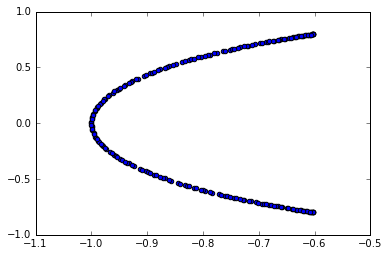

In [586]:
plt.scatter(real_x[:n, real_y)

In [441]:
env_model_predicted_outs.eval(feed_dict={
        env_model_ins: [[0., 0., 0., -4.],
                       [0., 0., 0., -1.],
                       [0., 0., 0., 0.],
                       [0., 0., 0., 1.],
                       [0., 0., 0., 2.]]
    })

array([[  7.099e-04,   1.872e-02,  -5.975e-01,   5.112e-04,   1.173e-03],
       [  9.416e-03,   1.931e-02,  -1.493e-01,   3.754e-04,   1.316e-03],
       [  9.929e-03,   1.939e-02,   8.366e-04,   3.274e-04,   1.368e-03],
       [  5.992e-03,   1.765e-02,   1.501e-01,   2.771e-04,   1.423e-03],
       [  1.100e-03,   1.481e-02,   3.005e-01,   2.357e-04,   1.454e-03]], dtype=float32)

In [592]:
"""
A simple example of an animated plot
"""
from matplotlib import animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(1, 200), init_func=init,
                              interval=25, blit=True)
plt.show()

ValueError: insecure string pickle